## Import packages

In [17]:
import gdown
import pandas as pd
import numpy as np
import seaborn as sns

## Load dataset

In [15]:
import gdown
file_id = "109Vs52lEMNEJEJtzvHGY0nTzsoeCi1zs"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=109Vs52lEMNEJEJtzvHGY0nTzsoeCi1zs
From (redirected): https://drive.google.com/uc?id=109Vs52lEMNEJEJtzvHGY0nTzsoeCi1zs&confirm=t&uuid=4c72dff0-a638-4f71-958b-42b7695dc8fe
To: C:\Users\romin\CCTcollege\Advanced data\ca1\msc-da-integrated-ca1-sem2-RKeuchkerian\dataset.csv
100%|██████████| 166M/166M [00:57<00:00, 2.89MB/s] 


'dataset.csv'

In [ ]:
#sns.pairplot(df)

In [ ]:
df.describe

In [24]:
df_polararea = df[["smiles", "polararea"]].dropna()  # Keep only SMILES & PSA columns
df_polararea.head()

,smiles,polararea
0,CN1CCC[C@H]1C2=CN=CC=C2,16.1
1,CC1(C(C1C(=O)OCC2=CC(=CC=C2)OC3=CC=CC=C3)C=C(C...,35.5
2,C[C@]12CC[C@](C[C@H]1C3=CC(=O)[C@@H]4[C@]5(CC[...,267.0
3,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,58.4
4,C1=CC=C(C(=C1)C(=O)O)O,57.5


In [26]:
print(df_polararea.isnull().sum())

smiles       0
polararea    0
dtype: int64


In [28]:
df_polararea.shape

(151966, 2)

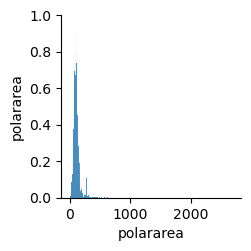

In [30]:
sns.pairplot(df_polararea)